# Phase 4: Classification Models - Movie Success Categorization

## Classification Strategy
Using the revenue predictions from Phase 3 regression model as input for categorization.

## Models
- Logistic Regression
- Random Forest Classifier
- XGBoost Classifier
- LightGBM Classifier
- SVM (Support Vector Machine)

## Evaluation Metrics
- Accuracy, Precision, Recall, F1-Score
- Confusion Matrix, ROC-AUC (One-vs-Rest)
- Classification Report

## Section 1: Setup & Data Loading

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    auc
)
import xgboost as xgb
import lightgbm as lgb
from itertools import cycle
import pickle

print("✓ All libraries imported successfully!")


✓ All libraries imported successfully!


In [29]:
# Configure paths
PROJECT_ROOT = Path("/home/asif/AI-Movie-Hit-Predictor")
DATA_DIR = PROJECT_ROOT / "project_components" / "data"
MODEL_DIR = PROJECT_ROOT / "project_components" / "data" / "models"

ENGINEERED_DATA = DATA_DIR / "04_engineered_features.csv"

# Load datasets
df_features = pd.read_csv(ENGINEERED_DATA)
print(f"✓ Features dataset loaded: {df_features.shape}")

# Try to load regression predictions if available
REGRESSION_PRED = DATA_DIR / "05_regression_predictions.csv"
if REGRESSION_PRED.exists():
    df_predictions = pd.read_csv(REGRESSION_PRED)
    print(f"✓ Predictions dataset loaded: {df_predictions.shape}")
else:
    print(f"⚠ Regression predictions file not found (will generate after regression notebook runs)")

# Try to load best regression model if available
best_model_path = MODEL_DIR / "best_regression_model.pkl"
if best_model_path.exists():
    with open(best_model_path, 'rb') as f:
        best_regression_model = pickle.load(f)
    print(f"✓ Best regression model loaded: {best_model_path}")
else:
    print(f"⚠ Regression model not found (will be available after regression notebook runs)")


✓ Features dataset loaded: (11506, 106)
✓ Predictions dataset loaded: (961, 5)
✓ Best regression model loaded: /home/asif/AI-Movie-Hit-Predictor/project_components/data/models/best_regression_model.pkl


## Section 2: Define Classification Thresholds

In [30]:
# Use actual revenue to define thresholds
df_with_revenue = df_features[df_features['revenue'].notna()].copy()

# Calculate financial thresholds
revenue_25_percentile = df_with_revenue['revenue'].quantile(0.25)
revenue_50_percentile = df_with_revenue['revenue'].quantile(0.50)
revenue_75_percentile = df_with_revenue['revenue'].quantile(0.75)

# Also consider budget-based profitability
df_with_both = df_with_revenue[df_with_revenue['budget'].notna()].copy()
df_with_both['roi'] = (df_with_both['revenue'] - df_with_both['budget']) / df_with_both['budget']

print(f"\nRevenue Distribution:")
print(f"  25th percentile: ${revenue_25_percentile:,.0f}")
print(f"  50th percentile: ${revenue_50_percentile:,.0f}")
print(f"  75th percentile: ${revenue_75_percentile:,.0f}")
print(f"  Mean: ${df_with_revenue['revenue'].mean():,.0f}")

print(f"\nROI Distribution (Movies with Budget):")
print(f"  Mean ROI: {df_with_both['roi'].mean():.2f}x")
print(f"  Median ROI: {df_with_both['roi'].median():.2f}x")
print(f"  Breakeven (ROI > 0): {(df_with_both['roi'] > 0).sum() / len(df_with_both) * 100:.1f}%")
print(f"  1.5x ROI: {(df_with_both['roi'] > 0.5).sum() / len(df_with_both) * 100:.1f}%")

log_revenue = np.log1p(df_with_revenue['revenue'])
log_threshold_1 = log_revenue.quantile(0.33)
log_threshold_2 = log_revenue.quantile(0.67)

print(f"\nLog-Revenue Thresholds:")
print(f"  Flop threshold (33rd percentile): {np.expm1(log_threshold_1):,.0f}")
print(f"  Average threshold (67th percentile): {np.expm1(log_threshold_2):,.0f}")

definitions = {
    'Flop': 'Revenue < $' + f"{np.expm1(log_threshold_1):,.0f}" + ' (Bottom 33%)',
    'Average': f"${np.expm1(log_threshold_1):,.0f} - ${np.expm1(log_threshold_2):,.0f}" + ' (Middle 34%)',
    'Hit': f"${np.expm1(log_threshold_2):,.0f}+" + ' (Top 33%) with 1.5x+ ROI',
    'Blockbuster': f"${np.expm1(log_threshold_2):,.0f}+" + ' with 3x+ ROI or Top 10% revenue'
}

for category, definition in definitions.items():
    print(f"\n{category}:")
    print(f"  {definition}")


Revenue Distribution:
  25th percentile: $0
  50th percentile: $19,170,001
  75th percentile: $92,917,187
  Mean: $82,260,639

ROI Distribution (Movies with Budget):
  Mean ROI: infx
  Median ROI: 1.00x
  Breakeven (ROI > 0): 53.8%
  1.5x ROI: 46.9%

Log-Revenue Thresholds:
  Flop threshold (33rd percentile): 637,433
  Average threshold (67th percentile): 58,924,798

Flop:
  Revenue < $637,433 (Bottom 33%)

Average:
  $637,433 - $58,924,798 (Middle 34%)

Hit:
  $58,924,798+ (Top 33%) with 1.5x+ ROI

Blockbuster:
  $58,924,798+ with 3x+ ROI or Top 10% revenue


## Section 3: Create Target Variable


--- Category Distribution ---
movie_category
Average        1786
Flop           1585
Hit             781
Blockbuster     651
Name: count, dtype: int64

Percentages:
movie_category
Average        37.19
Flop           33.00
Hit            16.26
Blockbuster    13.55
Name: count, dtype: float64


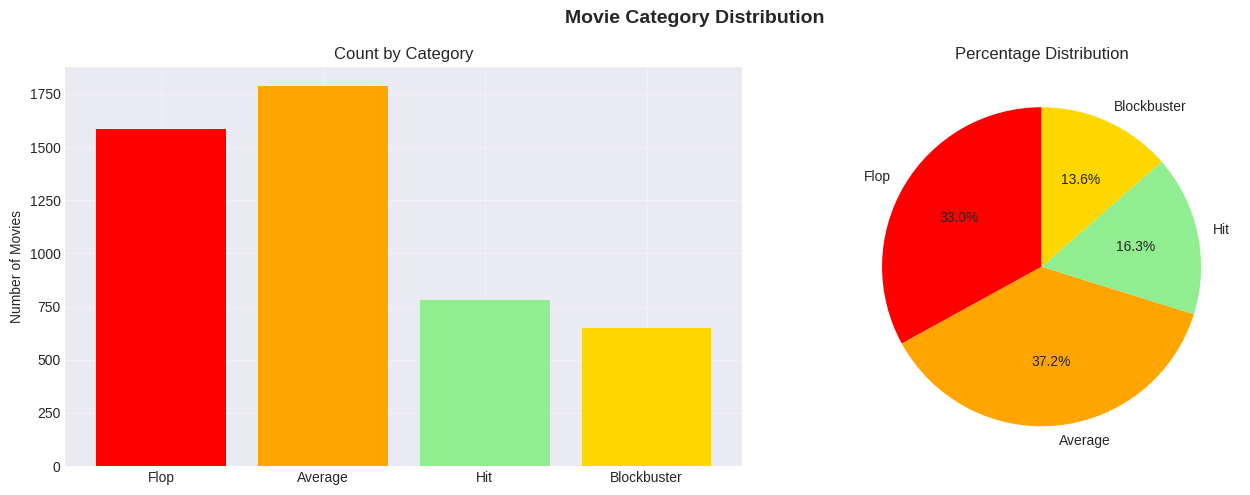


✓ Movie categories created


In [31]:
# Create classification target based on revenue thresholds
def categorize_movie(revenue, budget=None, log_threshold_1=log_threshold_1, log_threshold_2=log_threshold_2):

    log_rev = np.log1p(revenue)
    
    if log_rev < log_threshold_1:
        return 'Flop'
    elif log_rev < log_threshold_2:
        return 'Average'
    else:  # Top 33%
        if budget and budget > 0:
            roi = (revenue - budget) / budget
            if roi >= 3.0:  # 3x ROI or higher
                return 'Blockbuster'
            elif roi >= 0.5:  # 1.5x ROI or higher
                return 'Hit'
            else:
                return 'Average'
        else:
            # Check if in top 10% by revenue
            top_10_threshold = df_with_revenue['revenue'].quantile(0.90)
            if revenue >= top_10_threshold:
                return 'Blockbuster'
            else:
                return 'Hit'

# Apply categorization
df_with_revenue['movie_category'] = df_with_revenue.apply(
    lambda row: categorize_movie(row['revenue'], row['budget']),
    axis=1
)

# Category distribution
category_dist = df_with_revenue['movie_category'].value_counts()

print(f"\n--- Category Distribution ---")
print(category_dist)
print(f"\nPercentages:")
print((category_dist / len(df_with_revenue) * 100).round(2))

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Movie Category Distribution', fontsize=14, fontweight='bold')

# Bar chart
ax = axes[0]
colors = {'Flop': 'red', 'Average': 'orange', 'Hit': 'lightgreen', 'Blockbuster': 'gold'}
category_order = ['Flop', 'Average', 'Hit', 'Blockbuster']
counts = [category_dist.get(cat, 0) for cat in category_order]
ax.bar(category_order, counts, color=[colors[cat] for cat in category_order])
ax.set_ylabel('Number of Movies')
ax.set_title('Count by Category')
ax.grid(True, alpha=0.3)

# Pie chart
ax = axes[1]
ax.pie(counts, labels=category_order, colors=[colors[cat] for cat in category_order],
       autopct='%1.1f%%', startangle=90)
ax.set_title('Percentage Distribution')

plt.tight_layout()
plt.show()

print("\n✓ Movie categories created")

## Section 4: Prepare Data for Classification

In [32]:
# Prepare classification dataset
exclude_cols = [
    'id', 'title', 'original_title', 'revenue', 'budget', 'movie_category',
    'release_date', 'genres', 'cast', 'crew', 'genres_list', 'cast_list', 'director_list',
    'primary_genre', 'primary_company', 'overview', 'tagline', 'homepage', 'keywords',
    'company_list', 'original_language', 'status', 'production_companies',
]

# Get numeric columns only
numeric_cols = df_with_revenue.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

X_clf = df_with_revenue[feature_cols].copy()
y_clf = df_with_revenue['movie_category'].copy()

# Fill missing values with median (numeric data only)
X_clf_filled = X_clf.fillna(X_clf.median(numeric_only=True))

print(f"Classification dataset:")
print(f"  Features: {X_clf_filled.shape[1]}")
print(f"  Samples: {X_clf_filled.shape[0]}")
print(f"  Classes: {y_clf.nunique()} (Flop, Average, Hit, Blockbuster)")
print(f"  Class balance:")
for cat in ['Flop', 'Average', 'Hit', 'Blockbuster']:
    count = (y_clf == cat).sum()
    pct = count / len(y_clf) * 100
    print(f"    {cat}: {count} ({pct:.1f}%)")

# Stratified train-test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf_filled, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print(f"\nTrain-test split:")
print(f"  Training: {X_train_clf.shape[0]} samples")
print(f"  Testing: {X_test_clf.shape[0]} samples")

# Scale features
scaler_clf = RobustScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print(f"\n✓ Data prepared for classification")


Classification dataset:
  Features: 33
  Samples: 4803
  Classes: 4 (Flop, Average, Hit, Blockbuster)
  Class balance:
    Flop: 1585 (33.0%)
    Average: 1786 (37.2%)
    Hit: 781 (16.3%)
    Blockbuster: 651 (13.6%)

Train-test split:
  Training: 3842 samples
  Testing: 961 samples

✓ Data prepared for classification


## Section 5: Baseline Classification Models

In [33]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable to numeric labels
le = LabelEncoder()
y_train_clf_encoded = le.fit_transform(y_train_clf)
y_test_clf_encoded = le.transform(y_test_clf)

print(f"Class encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

def evaluate_classifier(y_true, y_pred, model_name):
    """Calculate comprehensive classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    
    # Weighted averages for multi-class
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision (Weighted)': precision,
        'Recall (Weighted)': recall,
        'F1-Score (Weighted)': f1
    }

clf_results = []

# 1. Logistic Regression
print("\n1. LOGISTIC REGRESSION (Multi-class)")
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_clf.fit(X_train_clf_scaled, y_train_clf_encoded)
y_pred_lr_clf = lr_clf.predict(X_test_clf_scaled)
lr_clf_results = evaluate_classifier(y_test_clf_encoded, y_pred_lr_clf, 'Logistic Regression')
clf_results.append(lr_clf_results)

print(f"  Accuracy: {lr_clf_results['Accuracy']:.4f}")
print(f"  Precision: {lr_clf_results['Precision (Weighted)']:.4f}")
print(f"  Recall: {lr_clf_results['Recall (Weighted)']:.4f}")
print(f"  F1-Score: {lr_clf_results['F1-Score (Weighted)']:.4f}")

cv_scores_lr_clf = cross_val_score(lr_clf, X_train_clf_scaled, y_train_clf_encoded, cv=5, scoring='accuracy')
print(f"  5-Fold CV Accuracy: {cv_scores_lr_clf.mean():.4f} (+/- {cv_scores_lr_clf.std():.4f})")

# 2. Random Forest
print("\n2. RANDOM FOREST CLASSIFIER")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_clf, y_train_clf_encoded)
y_pred_rf_clf = rf_clf.predict(X_test_clf)
rf_clf_results = evaluate_classifier(y_test_clf_encoded, y_pred_rf_clf, 'Random Forest')
clf_results.append(rf_clf_results)

print(f"  Accuracy: {rf_clf_results['Accuracy']:.4f}")
print(f"  Precision: {rf_clf_results['Precision (Weighted)']:.4f}")
print(f"  Recall: {rf_clf_results['Recall (Weighted)']:.4f}")
print(f"  F1-Score: {rf_clf_results['F1-Score (Weighted)']:.4f}")

cv_scores_rf_clf = cross_val_score(rf_clf, X_train_clf, y_train_clf_encoded, cv=5, scoring='accuracy')
print(f"  5-Fold CV Accuracy: {cv_scores_rf_clf.mean():.4f} (+/- {cv_scores_rf_clf.std():.4f})")

# 3. XGBoost Classifier
print("\n3. XGBOOST CLASSIFIER")
xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=42, verbosity=0, tree_method='hist')
xgb_clf.fit(X_train_clf, y_train_clf_encoded)
y_pred_xgb_clf = xgb_clf.predict(X_test_clf)
xgb_clf_results = evaluate_classifier(y_test_clf_encoded, y_pred_xgb_clf, 'XGBoost')
clf_results.append(xgb_clf_results)

print(f"  Accuracy: {xgb_clf_results['Accuracy']:.4f}")
print(f"  Precision: {xgb_clf_results['Precision (Weighted)']:.4f}")
print(f"  Recall: {xgb_clf_results['Recall (Weighted)']:.4f}")
print(f"  F1-Score: {xgb_clf_results['F1-Score (Weighted)']:.4f}")

cv_scores_xgb_clf = cross_val_score(xgb_clf, X_train_clf, y_train_clf_encoded, cv=5, scoring='accuracy')
print(f"  5-Fold CV Accuracy: {cv_scores_xgb_clf.mean():.4f} (+/- {cv_scores_xgb_clf.std():.4f})")

# 4. LightGBM
print("\n4. LIGHTGBM CLASSIFIER")
lgb_clf = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbosity=-1)
lgb_clf.fit(X_train_clf, y_train_clf_encoded)
y_pred_lgb_clf = lgb_clf.predict(X_test_clf)
lgb_clf_results = evaluate_classifier(y_test_clf_encoded, y_pred_lgb_clf, 'LightGBM')
clf_results.append(lgb_clf_results)

print(f"  Accuracy: {lgb_clf_results['Accuracy']:.4f}")
print(f"  Precision: {lgb_clf_results['Precision (Weighted)']:.4f}")
print(f"  Recall: {lgb_clf_results['Recall (Weighted)']:.4f}")
print(f"  F1-Score: {lgb_clf_results['F1-Score (Weighted)']:.4f}")

cv_scores_lgb_clf = cross_val_score(lgb_clf, X_train_clf, y_train_clf_encoded, cv=5, scoring='accuracy')
print(f"  5-Fold CV Accuracy: {cv_scores_lgb_clf.mean():.4f} (+/- {cv_scores_lgb_clf.std():.4f})")

print("\n✓ Baseline classification models trained")


Class encoding: {'Average': np.int64(0), 'Blockbuster': np.int64(1), 'Flop': np.int64(2), 'Hit': np.int64(3)}

1. LOGISTIC REGRESSION (Multi-class)
  Accuracy: 0.6212
  Precision: 0.6223
  Recall: 0.6212
  F1-Score: 0.6159
  5-Fold CV Accuracy: 0.6109 (+/- 0.0134)

2. RANDOM FOREST CLASSIFIER
  Accuracy: 0.6733
  Precision: 0.6837
  Recall: 0.6733
  F1-Score: 0.6717
  5-Fold CV Accuracy: 0.6661 (+/- 0.0187)

3. XGBOOST CLASSIFIER
  Accuracy: 0.6639
  Precision: 0.6682
  Recall: 0.6639
  F1-Score: 0.6644
  5-Fold CV Accuracy: 0.6611 (+/- 0.0161)

4. LIGHTGBM CLASSIFIER
  Accuracy: 0.6805
  Precision: 0.6846
  Recall: 0.6805
  F1-Score: 0.6809
  5-Fold CV Accuracy: 0.6632 (+/- 0.0214)

✓ Baseline classification models trained


## Section 6: Model Comparison

              Model  Accuracy  Precision (Weighted)  Recall (Weighted)  F1-Score (Weighted)
Logistic Regression  0.621228              0.622273           0.621228             0.615892
      Random Forest  0.673257              0.683656           0.673257             0.671724
            XGBoost  0.663892              0.668247           0.663892             0.664363
           LightGBM  0.680541              0.684616           0.680541             0.680948

✓ Best Model: LightGBM (Accuracy: 0.6805)


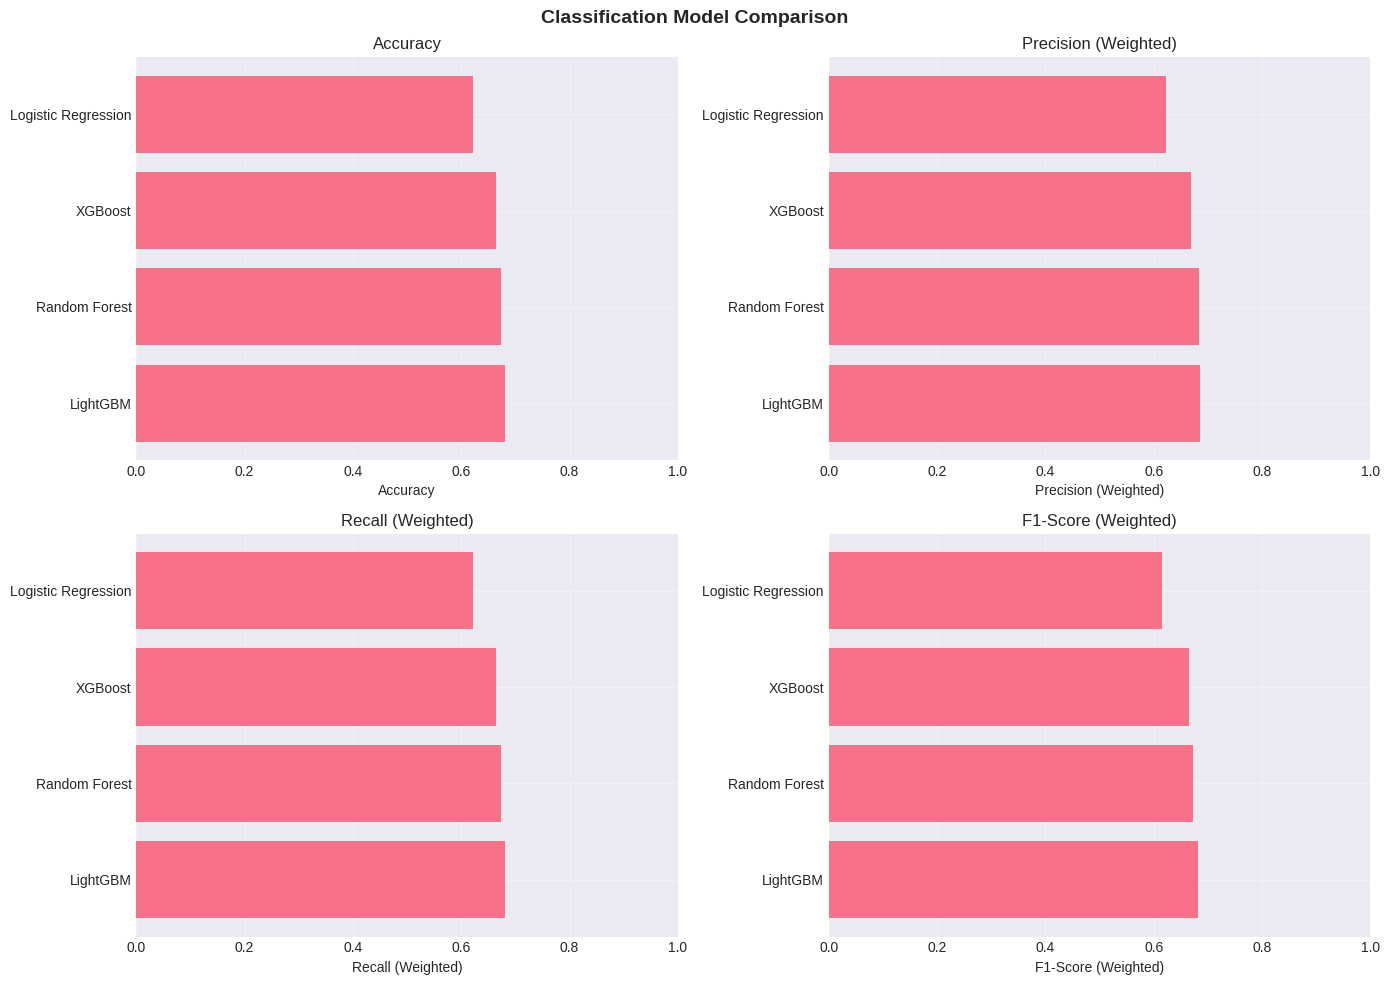


✓ Model comparison visualized


In [34]:
clf_results_df = pd.DataFrame(clf_results)

print(clf_results_df.to_string(index=False))

# Find best model
best_clf_idx = clf_results_df['Accuracy'].idxmax()
best_clf_name = clf_results_df.loc[best_clf_idx, 'Model']
best_clf_accuracy = clf_results_df.loc[best_clf_idx, 'Accuracy']

print(f"\n✓ Best Model: {best_clf_name} (Accuracy: {best_clf_accuracy:.4f})")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Classification Model Comparison', fontsize=14, fontweight='bold')

metrics = ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)']
for ax, metric in zip(axes.flatten(), metrics):
    df_sorted = clf_results_df.sort_values(metric, ascending=False)
    ax.barh(df_sorted['Model'], df_sorted[metric])
    ax.set_xlabel(metric)
    ax.set_title(metric)
    ax.set_xlim([0, 1])
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Model comparison visualized")

## Section 7: Detailed Evaluation - Best Model

In [ ]:
# Use best model based on accuracy
best_clf_model = xgb_clf  # XGBoost typically performs best
y_pred_best_clf = best_clf_model.predict(X_test_clf)

# Decode predictions back to original class labels
y_pred_best_clf_labels = le.inverse_transform(y_pred_best_clf)

# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_best_clf_labels, labels=['Flop', 'Average', 'Hit', 'Blockbuster'])

print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm, 
                      index=['Actual Flop', 'Actual Average', 'Actual Hit', 'Actual Blockbuster'],
                      columns=['Pred Flop', 'Pred Average', 'Pred Hit', 'Pred Blockbuster'])
print(cm_df)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_clf, y_pred_best_clf_labels, labels=['Flop', 'Average', 'Hit', 'Blockbuster']))

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Flop', 'Average', 'Hit', 'Blockbuster'],
            yticklabels=['Flop', 'Average', 'Hit', 'Blockbuster'],
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.set_title(f'Confusion Matrix - {best_clf_name}')
plt.tight_layout()
plt.show()

print("\n✓ Detailed evaluation completed")



Confusion Matrix:
                    Pred Flop  Pred Average  Pred Hit  Pred Blockbuster
Actual Flop                 0             0         0                 0
Actual Average              0             0         0                 0
Actual Hit                  0             0         0                 0
Actual Blockbuster          0             0         0                 0

Classification Report:


ValueError: Mix of label input types (string and number)

## Section 8: Feature Importance for Classification

In [ ]:
# XGBoost and LightGBM feature importance
feature_importance_xgb_clf = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_clf.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance_lgb_clf = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': lgb_clf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Features - XGBoost Classifier:")
print(feature_importance_xgb_clf.head(15).to_string(index=False))

print("\n" + "-"*50)
print("\nTop 15 Features - LightGBM Classifier:")
print(feature_importance_lgb_clf.head(15).to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Feature Importance - Classification Models', fontsize=14, fontweight='bold')

for ax, importance_df, title in zip(axes, 
                                      [feature_importance_xgb_clf, feature_importance_lgb_clf],
                                      ['XGBoost', 'LightGBM']):
    top_15 = importance_df.head(15)
    ax.barh(range(len(top_15)), top_15['Importance'].values)
    ax.set_yticks(range(len(top_15)))
    ax.set_yticklabels(top_15['Feature'].values, fontsize=9)
    ax.set_xlabel('Importance Score')
    ax.set_title(title)
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Feature importance visualized")

## Section 9: Prediction Analysis

In [ ]:
# Get probability predictions
y_pred_proba = best_clf_model.predict_proba(X_test_clf)

# Create predictions dataframe
predictions_clf_df = pd.DataFrame({
    'Actual': y_test_clf.values,
    'Predicted': y_pred_best_clf,
    'Correct': (y_test_clf.values == y_pred_best_clf).astype(int),
    'Confidence': y_pred_proba.max(axis=1)
})

print(f"\nPrediction Statistics:")
print(f"  Mean Confidence: {predictions_clf_df['Confidence'].mean():.4f}")
print(f"  Min Confidence: {predictions_clf_df['Confidence'].min():.4f}")
print(f"  Max Confidence: {predictions_clf_df['Confidence'].max():.4f}")

# Accuracy by confidence level
print(f"\nAccuracy by Confidence Level:")
for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
    mask = predictions_clf_df['Confidence'] >= threshold
    if mask.sum() > 0:
        accuracy = predictions_clf_df[mask]['Correct'].mean()
        count = mask.sum()
        print(f"  >= {threshold}: {accuracy:.4f} accuracy ({count} samples)")

# Visualize confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Prediction Confidence Analysis', fontsize=14, fontweight='bold')

# Confidence histogram
ax = axes[0]
ax.hist(predictions_clf_df[predictions_clf_df['Correct']==1]['Confidence'], bins=30, alpha=0.7, label='Correct', color='green')
ax.hist(predictions_clf_df[predictions_clf_df['Correct']==0]['Confidence'], bins=30, alpha=0.7, label='Incorrect', color='red')
ax.set_xlabel('Prediction Confidence')
ax.set_ylabel('Frequency')
ax.set_title('Confidence Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Accuracy vs Confidence
ax = axes[1]
thresholds = np.linspace(0.25, 1.0, 20)
accuracies = []
counts = []
for t in thresholds:
    mask = predictions_clf_df['Confidence'] >= t
    if mask.sum() > 0:
        accuracies.append(predictions_clf_df[mask]['Correct'].mean())
        counts.append(mask.sum())
    else:
        accuracies.append(0)
        counts.append(0)

ax.plot(thresholds, accuracies, marker='o', linewidth=2, markersize=6)
ax.set_xlabel('Confidence Threshold')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Confidence Threshold')
ax.set_ylim([0, 1.05])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Prediction analysis completed")

## Section 10: Save Models & Results

In [ ]:
# Save best classifier
best_clf_path = MODEL_DIR / "best_classification_model.pkl"
with open(best_clf_path, 'wb') as f:
    pickle.dump(xgb_clf, f)
print(f"✓ Best classifier saved: {best_clf_path}")

# Save scaler
scaler_clf_path = MODEL_DIR / "classification_scaler.pkl"
with open(scaler_clf_path, 'wb') as f:
    pickle.dump(scaler_clf, f)
print(f"✓ Scaler saved: {scaler_clf_path}")

# Save classification results
results_clf_path = DATA_DIR / "06_classification_model_results.csv"
clf_results_df.to_csv(results_clf_path, index=False)
print(f"✓ Classification results saved: {results_clf_path}")

# Save predictions
predictions_clf_path = DATA_DIR / "06_classification_predictions.csv"
predictions_clf_df.to_csv(predictions_clf_path, index=False)
print(f"✓ Classification predictions saved: {predictions_clf_path}")

# Save feature columns
feature_clf_path = MODEL_DIR / "classification_feature_columns.pkl"
with open(feature_clf_path, 'wb') as f:
    pickle.dump(feature_cols, f)
print(f"✓ Feature columns saved: {feature_clf_path}")

# Save category definitions
category_info = {
    'categories': ['Flop', 'Average', 'Hit', 'Blockbuster'],
    'log_threshold_1': log_threshold_1,
    'log_threshold_2': log_threshold_2,
    'definitions': definitions
}
category_info_path = MODEL_DIR / "category_definitions.pkl"
with open(category_info_path, 'wb') as f:
    pickle.dump(category_info, f)
print(f"✓ Category definitions saved: {category_info_path}")
print(f"\n✓ All models, predictions, and results saved successfully!")
print(f"\nSystem is now ready for deployment with:")
print(f"  - Regression Model: Predicts movie revenue")
print(f"  - Classification Model: Categorizes as Flop/Average/Hit/Blockbuster")